# Proximal Policy Optimization (PPO)

In [ ]:
# !pip3 install stable-baselines3
# !pip3 install shimmy>=0.2.1

In [ ]:
from copy import deepcopy
from tqdm import tqdm
import random
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import EvalCallback
from typing import Any, Dict
import numpy as np
from itertools import product
import torch
import time
import gym
from gym import spaces
import matplotlib.pyplot as plt
from gym.wrappers.normalize import NormalizeObservation, NormalizeReward, RunningMeanStd
import math
import datetime
import copy
from itertools import product
np.set_printoptions(precision=3)

In [ ]:
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")

In [9]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()


    def reset(self):
        self.change_tyre(self.default_tyre)


    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)


    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00


    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel


class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()


    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()


    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]


    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False

        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125

        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

# Agent

In [10]:
class Agent:
    def __init__(self):
        self.loaded_model = PPO.load("./Model/best_model_PPO.zip")
        self.rescale = True

    def rescaler(self, input, low, high):
        """Rescale the input value to the range [-1, 1].
        Args:
            input (float): Input value to be rescaled.
            low (float): Lower bound of the rescaling range.
            high (float): Upper bound of the rescaling range.
        Returns:
            float: Rescaled value.
        """
        return 2.0 * (input - low) / (high - low) - 1.0

    def _convert_observation(self, observation):
        """Converts the raw observation into a rescaled dictionary of observations.
        Args:
            observation (list): Raw observation data.
        Returns:
            dict: Rescaled observation data.
        """
        # Mapping for tire types
        tire_type_mapping = {
            "Ultrasoft": 0, "Soft": 1, "Intermediate": 2, "Fullwet": 3
        }
        # Mapping for weather conditions
        weather_mapping = {
            "Dry": 0, "20% Wet": 1, "40% Wet": 2, "60% Wet": 3, "80% Wet": 4, "100% Wet": 5
        }

        # Map observations
        tire_type = np.array([tire_type_mapping[observation[0]]])
        weather = np.array([weather_mapping[observation[2]]])

        # Rescale observations
        if self.rescale:
            car_condition = np.array([self.rescaler(observation[1], low=0.0, high=1.0)])
            radius = np.array([self.rescaler(float(observation[3]), low=600.0, high=1200.0)])
            laps_cleared = np.array([self.rescaler(float(observation[4]), low=0.0, high=162.0)])
        else:
            car_condition = np.array([observation[1]])
            radius = np.array([float(observation[3])])
            laps_cleared = np.array([float(observation[4])])

        # Return observations as a dictionary
        return {'tire_type': tire_type,
                'car_condition': car_condition,
                'weather': weather,
                'radius': radius,
                'laps_cleared': laps_cleared
        }

    def act(self, state):
        state = self._convert_observation(state)
        action, _ = self.loaded_model.predict(state)
        return int(action)

# Custom Environment

The custom environments come in 4 different combinations:
1. No rescaling and no reward shaping
2. Has rescaling but no reward shaping
3. No rescaling but has reward shaping
4. Has both rescaling and reward shaping

Rescaling observations in Proximal Policy Optimization (PPO) is done to normalize the input data to the range [-1, 1], potentially encouraging the neural network used for policy approximation to learn more effectively across a consistent and stable input range.

Reward shaping is employed to modify the immediate rewards in a reinforcement learning task, making the learning process more efficient and guiding the agent towards desirable behavior by providing intermediate rewards that encourage desired actions and discourage undesired ones.

The following environments were created to assess the effectiveness of these two methods for this problem.

In [11]:
class CustomRacingEnv(gym.Env):
    """A custom environment that enables compatibility with the gym environment.
    """
    def __init__(self, car, rescale=False, reward_shaping=False):
        super(CustomRacingEnv, self).__init__()
        self.track = Track(car)
        self.rescale = rescale
        self.reward_shaping = reward_shaping
        self.radius = None
        # Define action and observation spaces
        self.action_space = spaces.Discrete(5)  # 0-4 actions

        # Define observation space
        self.observation_space = spaces.Dict({
            'tire_type': spaces.Discrete(4),
            'car_condition': spaces.Box(low=np.array([-1.0]), high=np.array([1.0]), shape=(1,), dtype=np.float32),
            'weather': spaces.Discrete(6),
            'radius': spaces.Box(low=np.array([-1.0]), high=np.array([1.0]), shape=(1,), dtype=np.float32),
            'laps_cleared': spaces.Box(low=np.array([-1.0]), high=np.array([1.0]), shape=(1,), dtype=np.float32)
        })

        # Mapping for tire types
        self.tire_type_mapping = {
            "Ultrasoft": 0, "Soft": 1, "Intermediate": 2, "Fullwet": 3
        }
        # Mapping for weather conditions
        self.weather_mapping = {
            "Dry": 0, "20% Wet": 1, "40% Wet": 2, "60% Wet": 3, "80% Wet": 4, "100% Wet": 5
        }

    def _convert_observation(self, observation):
        """Converts the raw observation into a rescaled dictionary of observations.
        Args:
            observation (list): Raw observation data.
        Returns:
            dict: Rescaled observation data.
        """
        # Map observations
        tire_type = np.array([self.tire_type_mapping[observation[0]]])
        weather = np.array([self.weather_mapping[observation[2]]])

        # Rescale observations
        if self.rescale:
            car_condition = np.array([self.rescaler(observation[1], low=0.0, high=1.0)])
            radius = np.array([self.rescaler(float(observation[3]), low=600.0, high=1200.0)])
            laps_cleared = np.array([self.rescaler(float(observation[4]), low=0.0, high=162.0)])
        else:
            car_condition = np.array([observation[1]])
            radius = np.array([float(observation[3])])
            laps_cleared = np.array([float(observation[4])])

        # Return observations as a dictionary
        return {'tire_type': tire_type,
                'car_condition': car_condition,
                'weather': weather,
                'radius': radius,
                'laps_cleared': laps_cleared
        }

    def step(self, action):
        """Execute a step in the environment based on the given action.
        Args:
            action (int): Action to be taken.
        Returns:
            tuple: Tuple containing the next observation, reward, done flag, and additional information.
        """
        reward, next_state, done, velocity = self.track.transition(int(action))

        if self.reward_shaping:
            weather_reward = 0
            # Reward for tire condition management
            car_condition_reward = 20 * next_state[1]
            tire_change_penalty = -25 if action < 4 else 0  # Penalize for unnecessary tire changes

            # [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
            # Reward for weather-dependent tire choice
            if next_state[2] == "Dry" and next_state[0] in ["Ultrasoft", "Soft"]:
                if next_state[1] > 0.8 and action == 4:
                    weather_reward += 20  # tyres good condition
                if next_state[1] < 0.7 and action == 4:
                    if action == 4:
                        weather_reward -= 20  # don't change
                    elif action == 0:
                        weather_reward += 20  # change to the right tyres
                    elif action == 1:
                        weather_reward += 10  # change to right but not best tyres
                    else:
                        weather_reward -= 20  # change to the wrong tyres

            if next_state[2] in ["60% Wet", "80% Wet", "100% Wet"] and next_state[0] == "Fullwet":
                if next_state[1] > 0.8 and action == 4:
                    weather_reward += 20  # tyres good condition
                if next_state[1] < 0.7 and action == 4:  # worn out tyres
                    if action == 4:
                        weather_reward -= 20  # don't change
                    elif action == 3:
                        weather_reward += 20  # change to the right tyres
                    elif action == 2:
                        weather_reward -= 10  # change to wrong but not wrost tyres
                    else:
                        weather_reward -= 20  # change to the wrong tyres

            if next_state[2] in ["20% Wet", "40% Wet"] and next_state[0] == "Intermediate":
                if next_state[1] > 0.8 and action == 4:
                    weather_reward += 20  # tyres good condition
                if next_state[1] < 0.7: # worn out tyres
                    if action == 4:
                        weather_reward -= 20  # don't change
                    elif action == 2:
                        weather_reward += 20  # change to the right tyres
                    else:
                        weather_reward -= 20  # change to the wrong tyres

            # Reward for lap time reduction
            lap_time_reward = 100 if next_state[4] == 161.75 and action == 4 else -100

            # Combine rewards
            reward += car_condition_reward + tire_change_penalty + weather_reward + lap_time_reward

        obs = self._convert_observation(next_state)

        return obs, reward, done, {'velocity': velocity}

    def reset(self, **kwargs):
        """Reset the environment to its initial state.
        Returns:
            dict: modified observations.
        """
        state = self.track.reset()

        if self.radius != None:
            self.track.radius = self.radius
            state[3] = self.radius

        obs = self._convert_observation(state)

        return obs

    def render(self, mode="human"):
        pass

    def close(self):
        pass

    def rescaler(self, input, low, high):
        """Rescale the input value to the range [-1, 1].
        Args:
            input (float): Input value to be rescaled.
            low (float): Lower bound of the rescaling range.
            high (float): Upper bound of the rescaling range.
        Returns:
            float: Rescaled value.
        """
        return 2.0 * (input - low) / (high - low) - 1.0

In [15]:
def evaluate_model(model_path, env, iterations=10):
    """
    Evaluate a trained PPO model on an environment with different radii.

    Args:
        model_path (str): The path to the saved PPO model.
        env (gym.Env): The wrapped environment.
        iterations (int): The number of iterations to run the evaluation.

    Returns:
        dict: A dictionary containing max, min, and average returns for different radii.
    """
    model = PPO.load(model_path + "best_model.zip")
    all_g = {"max": [], "min": [], "avg":[]}
    print(f'Averaged over {iterations} iterations')
    for radius in [600, 700, 800, 900, 1000, 1100, 1200]:
        G_list = []
        for iteration in range(iterations):
            env.radius = radius
            state = env.reset()
            done = False
            G = 0
            while not done:
                action, _ = model.predict(state)
                next_state, reward, done, velocity = env.step(action)
                # added velocity for sanity check
                state = copy.deepcopy(next_state)
                G += reward
            G_list.append(G)
        print(f"\nRadius: {radius}, min G: {np.min(G_list)}")
        print(f"Radius: {radius}, avg G: {np.mean(G_list)}")
        print(f"Radius: {radius}, max G: {np.max(G_list)}\n")
        all_g["max"].append(np.max(G_list))
        all_g["min"].append(np.min(G_list))
        all_g["avg"].append(np.mean(G_list))
    return all_g

### Instantiate Class Objects

In [ ]:
CustomRaceTrack_1 = CustomRacingEnv(Car(), rescale=False, reward_shaping=False)
CustomRaceTrack_2 = CustomRacingEnv(Car(), rescale=True, reward_shaping=False)
CustomRaceTrack_3 = CustomRacingEnv(Car(), rescale=False, reward_shaping=True)
CustomRaceTrack_4 = CustomRacingEnv(Car(), rescale=True, reward_shaping=True)

# Test Case 1. Rescaling [No], Reward Shaping [No]

In [ ]:
CustomRaceTrack_1.radius = 1200
model_file_path_1 = './logs/CustomRacingEnv_1/'

model_1 = PPO("MultiInputPolicy", CustomRaceTrack_1)

model_1.learn(
    total_timesteps=50000,
    callback=EvalCallback(
        CustomRaceTrack_1, best_model_save_path=model_file_path_1, eval_freq=1000
    )
)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: E

Eval num_timesteps=1000, episode_reward=-20080.67 +/- 11.41
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-20093.85 +/- 18.61
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-72675.49 +/- 163.52
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-72546.51 +/- 191.69
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-20076.64 +/- 68.85
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=6000, episode_reward=-20081.48 +/- 82.88
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-72687.99 +/- 79.39
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-72543.41 +/- 156.63
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-19966.20 +/- 60.74
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-19988.01 +/- 59.17
Episode length: 1296.00 +/- 0.00


In [34]:
result_case1 = evaluate_model(model_path=model_file_path_1, env=CustomRaceTrack_1)

Averaged over 10 iterations

Radius: 600, min G: -11963.81748928114
Radius: 600, avg G: -11891.476429997958
Radius: 600, max G: -11811.492733844183


Radius: 700, min G: -13449.925552790352
Radius: 700, avg G: -13297.575791065066
Radius: 700, max G: -13237.30634584136


Radius: 800, min G: -14902.593394532098
Radius: 800, avg G: -14700.372646844908
Radius: 800, max G: -14580.218147253308


Radius: 900, min G: -16172.20631820828
Radius: 900, avg G: -16061.3591291005
Radius: 900, max G: -15996.498350638232


Radius: 1000, min G: -17636.171344824288
Radius: 1000, avg G: -17415.272037234565
Radius: 1000, max G: -17330.76017844753


Radius: 1100, min G: -18810.947563297646
Radius: 1100, avg G: -18720.533726801103
Radius: 1100, max G: -18651.07862762241


Radius: 1200, min G: -20181.869944387116
Radius: 1200, avg G: -20063.483338782913
Radius: 1200, max G: -19956.202460979952


# Test Case 2. Rescaling [Yes], Reward Shaping [No]

In [ ]:
CustomRaceTrack_2.radius = 1200
model_file_path_2 = './logs/CustomRacingEnv_2/'

model_2 = PPO("MultiInputPolicy", CustomRaceTrack_2)

model_2.learn(
    total_timesteps=50000,
    callback=EvalCallback(
        CustomRaceTrack_2, best_model_save_path=model_file_path_2, eval_freq=1000
    )
)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Eval num_timesteps=1000, episode_reward=-20395.99 +/- 207.86
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-20933.73 +/- 461.45
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-20110.95 +/- 56.07
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-20085.72 +/- 13.26
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-58975.19 +/- 5726.14
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-59740.62 +/- 6704.33
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-49680.67 +/- 5118.48
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-52513.77 +/- 7374.10
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-20163.54 +/- 114.46
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-20133.84 +/- 126.59
Episode length: 1296.00 

In [33]:
result_case2 = evaluate_model(model_path=model_file_path_2, env=CustomRaceTrack_2)

Averaged over 10 iterations

Radius: 600, min G: -11931.001451042053
Radius: 600, avg G: -11879.16081605907
Radius: 600, max G: -11828.23776441517


Radius: 700, min G: -13342.286353110281
Radius: 700, avg G: -13268.83763748121
Radius: 700, max G: -13173.814755173413


Radius: 800, min G: -14782.385484078508
Radius: 800, avg G: -14681.728017979734
Radius: 800, max G: -14584.183326894998


Radius: 900, min G: -16105.863005305766
Radius: 900, avg G: -16031.439685750685
Radius: 900, max G: -15963.033255743825


Radius: 1000, min G: -17468.229559723135
Radius: 1000, avg G: -17369.302391713525
Radius: 1000, max G: -17272.291766689268


Radius: 1100, min G: -18761.586480290076
Radius: 1100, avg G: -18694.947290085714
Radius: 1100, max G: -18617.57671664353


Radius: 1200, min G: -20148.917024107584
Radius: 1200, avg G: -20026.206924532475
Radius: 1200, max G: -19941.712809252105


# Test Case 3. Rescaling [No], Reward Shaping [Yes]

In [ ]:
CustomRaceTrack_3.radius = 1200
model_file_path_3 = './logs/CustomRacingEnv_3/'

model_3 = PPO("MultiInputPolicy", CustomRaceTrack_3)

model_3.learn(
    total_timesteps=50000,
    callback=EvalCallback(
        CustomRaceTrack_3, best_model_save_path=model_file_path_3, eval_freq=1000
    )
)

Eval num_timesteps=1000, episode_reward=-162086.31 +/- 448.65
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-162368.16 +/- 805.34
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-208876.47 +/- 3543.35
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-205642.52 +/- 2897.49
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-212396.24 +/- 4088.48
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-210171.94 +/- 2125.46
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-206978.85 +/- 4842.63
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-205986.63 +/- 3032.89
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-209385.13 +/- 4049.45
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-210179.00 +/- 3317.07
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=

In [32]:
result_case3 = evaluate_model(model_path=model_file_path_3, env=CustomRaceTrack_2) # Test in the env without reward shaping

Averaged over 10 iterations

Radius: 600, min G: -11945.734666861816
Radius: 600, avg G: -11879.576617414787
Radius: 600, max G: -11836.319518595572


Radius: 700, min G: -13435.01413610137
Radius: 700, avg G: -13286.634934776539
Radius: 700, max G: -13211.36740991476


Radius: 800, min G: -14799.60779664564
Radius: 800, avg G: -14679.741931319513
Radius: 800, max G: -14603.476983202516


Radius: 900, min G: -16334.500469774786
Radius: 900, avg G: -16059.260480532539
Radius: 900, max G: -15944.01777160026


Radius: 1000, min G: -17518.453955372075
Radius: 1000, avg G: -17414.852668868676
Radius: 1000, max G: -17352.28428126192


Radius: 1100, min G: -18911.933877135445
Radius: 1100, avg G: -18713.033228139044
Radius: 1100, max G: -18596.440887029574


Radius: 1200, min G: -20283.034431943222
Radius: 1200, avg G: -20059.612601444904
Radius: 1200, max G: -19928.531763947205


# Test Case 4. Rescaling [Yes], Reward Shaping [Yes]

In [ ]:
CustomRaceTrack_4.radius = 1200
model_file_path_4 = './logs/CustomRacingEnv_4/'

model_4 = PPO("MultiInputPolicy", CustomRaceTrack_4)

model_4.learn(
    total_timesteps=50000,
    callback=EvalCallback(
        CustomRaceTrack_4, best_model_save_path=model_file_path_4, eval_freq=1000
    )
)

Eval num_timesteps=1000, episode_reward=-158085.39 +/- 105.38
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-158115.15 +/- 47.16
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-209245.57 +/- 5135.37
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-206500.96 +/- 2670.64
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-209922.46 +/- 5737.28
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-210190.44 +/- 3881.44
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-208838.18 +/- 1705.41
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-210256.55 +/- 5248.94
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-210789.40 +/- 1488.93
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-208562.56 +/- 1700.77
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=1

In [31]:
result_case4 = evaluate_model(model_path=model_file_path_4, env=CustomRaceTrack_2) # Test in the env without reward shaping

Averaged over 10 iterations

Radius: 600, min G: -11974.111271979184
Radius: 600, avg G: -11880.790229842149
Radius: 600, max G: -11814.500508924395


Radius: 700, min G: -13445.706391072135
Radius: 700, avg G: -13289.663575555494
Radius: 700, max G: -13197.500293501942


Radius: 800, min G: -14742.95178961832
Radius: 800, avg G: -14664.608381396194
Radius: 800, max G: -14584.50262645518


Radius: 900, min G: -16153.464937443314
Radius: 900, avg G: -16056.175715649431
Radius: 900, max G: -15983.096786393948


Radius: 1000, min G: -17467.249638904537
Radius: 1000, avg G: -17391.07800669071
Radius: 1000, max G: -17305.4616838973


Radius: 1100, min G: -18856.63682756249
Radius: 1100, avg G: -18711.88334350833
Radius: 1100, max G: -18642.911296560404


Radius: 1200, min G: -20150.881303404807
Radius: 1200, avg G: -20065.14048029581
Radius: 1200, max G: -19992.78154895319


# Best PPO Model

### The best PPO Model was trained with the **CustomRaceTrack_2** environment (has observation rescaling but no reward shaping) for 500,000 time steps. The evaluation is based on the average of 50 iterations.

In [28]:
track_1 = Track(Car())
agent_1 = Agent()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
iterations = 50
result_opt = {"max": [], "min": [], "avg":[]}
print(f'Averaged over {iterations} iterations')
for radius in [600, 700, 800, 900, 1000, 1100, 1200]:
    G_list = []
    for iteration in range(iterations):
        track_1.reset()
        track_1.radius = radius
        state = track_1._get_state()
        done = False
        G = 0
        while not done:
            action = agent_1.act(state)
            reward, next_state, done, velocity = track_1.transition(action)
            # added velocity for sanity check
            state = copy.deepcopy(next_state)
            G += reward
        G_list.append(G)
    print(f"\nRadius: {radius}, min G: {np.min(G_list)}")
    print(f"Radius: {radius}, avg G: {np.mean(G_list)}")
    print(f"Radius: {radius}, max G: {np.max(G_list)}\n")
    result_opt["max"].append(np.max(G_list))
    result_opt["min"].append(np.min(G_list))
    result_opt["avg"].append(np.mean(G_list))
result_opt

Averaged over 50 iterations

Radius: 600, min G: -11515.42940674654
Radius: 600, avg G: -11427.458324256384
Radius: 600, max G: -11324.827457730746


Radius: 700, min G: -13029.995195140511
Radius: 700, avg G: -12896.844209935829
Radius: 700, max G: -12795.80924254445


Radius: 800, min G: -14509.360370120225
Radius: 800, avg G: -14354.51442999304
Radius: 800, max G: -14244.756504406323


Radius: 900, min G: -15856.911567195033
Radius: 900, avg G: -15754.76077429582
Radius: 900, max G: -15635.922004030079


Radius: 1000, min G: -17277.104104319882
Radius: 1000, avg G: -17126.53087897182
Radius: 1000, max G: -16902.999820235065


Radius: 1100, min G: -18616.035504542226
Radius: 1100, avg G: -18469.245668024967
Radius: 1100, max G: -18295.22673160177


Radius: 1200, min G: -19907.26610179147
Radius: 1200, avg G: -19800.259304864536
Radius: 1200, max G: -19641.266174732362


{'max': [-11324.827457730746,
  -12795.80924254445,
  -14244.756504406323,
  -15635.922004030079,
  -16902.999820235065,
  -18295.22673160177,
  -19641.266174732362],
 'min': [-11515.42940674654,
  -13029.995195140511,
  -14509.360370120225,
  -15856.911567195033,
  -17277.104104319882,
  -18616.035504542226,
  -19907.26610179147],
 'avg': [-11427.458324256384,
  -12896.844209935829,
  -14354.51442999304,
  -15754.76077429582,
  -17126.53087897182,
  -18469.245668024967,
  -19800.259304864536]}

# 5. Hyperparameter Tuning

### Generate a set of all possible hyperparameter combinations as defined in the grid then randomly select 10 combinations to run through the pipeline

In [ ]:
# Define a hyperparameter grid
hyperparameter_grid = {
    #'policy': ['MlpPolicy', 'CnnPolicy'],  # Different policy models
    'learning_rate': [0.03, 0.003, 0.00003],  # Learning rates
    'n_steps': [4096, 2048, 1024, 512],  # Number of steps per update
    'batch_size': [256, 1024, 2048],  # Minibatch size
    'n_epochs': [128, 512, 1024], #4, 8, 16],  # Number of optimization epochs
    'gamma': [0.99, 0.8, 0.3],  # Discount factor
    'gae_lambda': [0.99, 0.95, 0.80, 0.6],  # GAE lambda
    'clip_range': [0.4, 0.6, 0.8],  # Clipping parameter for policy
    'ent_coef': [0.0, 0.01, 0.1],  # Entropy coefficient
    'vf_coef': [0.5, 0.7],  # Value function coefficient
    #'max_grad_norm': [0.5, 0.8],  # Maximum gradient norm
    #'sde_sample_freq': [100, 500],  # Frequency of sampling noise matrix
    'target_kl': [0.01, 0.05],  # Limit on KL divergence
    #'stats_window_size': [10, 20],  # Window size for rollout logging
    'device': ['auto'],  # Device to run on (auto or GPU)
}  #Training with hyperparameters: {'learning_rate': 0.03, 'n_steps': 1024, 'batch_size': 256, 'n_epochs': 128, 'gamma': 0.8, 'gae_lambda': 0.95, 'clip_range': 0.4, 'device': 'auto'}

# Generate all combinations of hyperparameters
all_hyperparam_combinations = list(product(*hyperparameter_grid.values()))

# Run hyperparameter tuning for random 10 combinations
all_hyperparam_combinations = random.sample(all_hyperparam_combinations, 10)

# Set random seed
random_seed = 42
random.seed(random_seed)

# Shuffle hyperparam combinations
random.shuffle(all_hyperparam_combinations)

best_model = None
best_mean_reward = -float('inf')
best_hyperparam = None

for hyperparams in all_hyperparam_combinations:
    start_time = time.time()
    hyperparameter_dict = {key: value for key, value in zip(hyperparameter_grid.keys(), hyperparams)}
    print("---------------------------------------------------------------------------------------")
    print(f"\nTraining with hyperparameters: {hyperparameter_dict}\n")
    # Create the PPO model with the current hyperparameters
    model = PPO("MultiInputPolicy", CustomRaceTrack_4, verbose=0, **hyperparameter_dict)

    save_to_path = './logs/5_hyperparam_tuning/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Train the model with the current hyperparameters
    model.learn(
        total_timesteps=20000,
        callback=EvalCallback(
            CustomRaceTrack_4, best_model_save_path=save_to_path, eval_freq=1000
        )
    )
    # Evaluate the model's performance

    model = PPO.load(save_to_path + "/best_model.zip")

    iterations = 10
    all_g = {"max": [], "min": [], "avg":[]}
    print(f'Averaged over {iterations} iterations')
    for radius in [600, 700, 800, 900, 1000, 1100, 1200]:
        G_list = []
        for iteration in range(iterations):
            env = CustomRaceTrack_2 # Test in the env without reward shaping
            env.radius = radius
            state = env.reset()
            done = False
            G = 0
            while not done:
                action, _ = model.predict(state)
                next_state, reward, done, velocity = env.step(action)
                # added velocity for sanity check
                state = copy.deepcopy(next_state)
                G += reward
            G_list.append(G)
        print(f"\nRadius: {radius}, min G: {np.min(G_list)}")
        print(f"Radius: {radius}, avg G: {np.mean(G_list)}")
        print(f"Radius: {radius}, max G: {np.max(G_list)}\n")

        all_g["max"].append(np.max(G_list))
        all_g["min"].append(np.min(G_list))
        all_g["avg"].append(np.mean(G_list))
    all_g

    # Consider models with the best avg rewards over all radiuses
    score = np.mean([value for sublist in all_g.values() for value in sublist])

    print(f"\nMean reward: {score}\n")
    if score > best_mean_reward:
        best_model = model
        best_mean_reward = score
        best_hyperparam = hyperparameter_dict
        best_model.save("best_PPO_model")
        print("\nSaved a new model\n")

    # Calculate and print the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nElapsed time: {elapsed_time:.2f} seconds\n")

---------------------------------------------------------------------------------------

Training with hyperparameters: {'learning_rate': 0.03, 'n_steps': 4096, 'batch_size': 2048, 'n_epochs': 512, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_range': 0.8, 'ent_coef': 0.1, 'vf_coef': 0.5, 'target_kl': 0.05, 'device': 'auto'}

Eval num_timesteps=1000, episode_reward=-145618.48 +/- 2486.66
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-142970.42 +/- 1228.92
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-142239.18 +/- 4038.27
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-145148.30 +/- 3027.81
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-208528.40 +/- 4400.00
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-208745.94 +/- 4676.31
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_re

/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 2048, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 512
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-210065.04 +/- 1925.65
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-207971.45 +/- 5509.33
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-207585.50 +/- 5302.90
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-204705.85 +/- 5043.92
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-209511.13 +/- 7810.87
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-208820.25 +/- 4663.43
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-208411.70 +/- 5529.47
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-168170.05 +/- 7136.36
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=9000, episode_reward=-141383.44 +/- 2863.96
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval

/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 1024, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 512
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-204318.24 +/- 6017.37
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-210399.99 +/- 4650.22
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-209593.59 +/- 2762.92
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-208059.57 +/- 5408.79
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-206637.11 +/- 3117.30
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-198220.52 +/- 7945.07
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=7000, episode_reward=-183546.60 +/- 4794.59
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=-195506.81 +/- 4536.36
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-209540.58 +/- 1892.26
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-209805.52 +/- 4668.81
Episod

In [ ]:
best_hyperparam

{'learning_rate': 3e-05,
 'n_steps': 2048,
 'batch_size': 256,
 'n_epochs': 512,
 'gamma': 0.8,
 'gae_lambda': 0.8,
 'clip_range': 0.4,
 'ent_coef': 0.1,
 'vf_coef': 0.7,
 'target_kl': 0.01,
 'device': 'auto'}

### Try Tuned Hyperparameters on Test Case 1

In [ ]:
CustomRaceTrack_1.radius = 1200
model_file_path_1_hyperparam = './logs/CustomRacingEnv_1_tuned_hyperparam/'

model_1 = PPO("MultiInputPolicy", CustomRaceTrack_1, **best_hyperparam)

model_1.learn(
    total_timesteps=50000,
    callback=EvalCallback(
        CustomRaceTrack_1, best_model_save_path=model_file_path_1_hyperparam, eval_freq=1000
    )
)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-19970.26 +/- 75.36
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-19908.47 +/- 51.19
Episode length: 1296.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-72701.15 +/- 155.51
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-72764.07 +/- 160.76
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-72750.39 +/- 139.08
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-72697.32 +/- 197.60
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-72694.60 +/- 182.68
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-72714.34 +/- 38.86
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-72722.71 +/- 129.92
Episode length: 1296.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-72605.94 +/- 164.53
Episode length: 1296.00 +/- 0.00
Eval num_timesteps

In [30]:
res_hyperparam = evaluate_model(model_path=model_file_path_1_hyperparam, env=CustomRaceTrack_1)

Averaged over 10 iterations

Radius: 600, min G: -11952.169083877101
Radius: 600, avg G: -11864.01951852158
Radius: 600, max G: -11800.513928174318


Radius: 700, min G: -13403.42266698121
Radius: 700, avg G: -13276.246538432
Radius: 700, max G: -13168.530982167083


Radius: 800, min G: -14920.894810206724
Radius: 800, avg G: -14710.301631319137
Radius: 800, max G: -14619.644195027884


Radius: 900, min G: -16085.495302303849
Radius: 900, avg G: -16038.654244326317
Radius: 900, max G: -15971.418137296616


Radius: 1000, min G: -17493.89409635263
Radius: 1000, avg G: -17374.447536615662
Radius: 1000, max G: -17238.884300005608


Radius: 1100, min G: -18976.838446568727
Radius: 1100, avg G: -18719.31334417736
Radius: 1100, max G: -18616.5792565261


Radius: 1200, min G: -20077.860821031445
Radius: 1200, avg G: -20028.945162709253
Radius: 1200, max G: -19971.85278740442


## Visualize Results

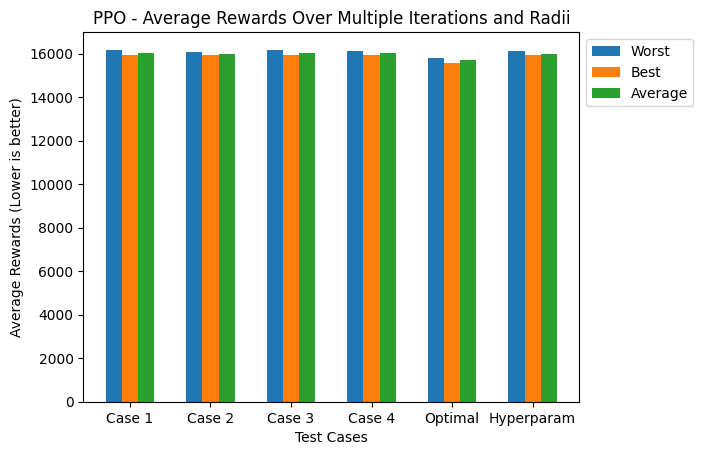

In [44]:
all_results = [result_case1, result_case2, result_case3, result_case4, result_opt, res_hyperparam]

# Initialize empty lists to store the averaged values
avg_min = []
avg_max = []
avg_avg = []

# Calculate the average for 'min,' 'max,' and 'avg' separately
for result in all_results:
    avg_min.append(abs(np.mean(result['min'])))
    avg_max.append(abs(np.mean(result['max'])))
    avg_avg.append(abs(np.mean(result['avg'])))

# Create a list of labels for the bars
labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Optimal', 'Hyperparam']

# Create a list of x-positions for the bars
x = np.arange(len(all_results))

# Set the width of the bars
width = 0.2

# Create the figure and axis objects
fig, ax = plt.subplots()

ax.bar(x - width, avg_min, width, label='Worst')
ax.bar(x, avg_max, width, label='Best')
ax.bar(x + width, avg_avg, width, label='Average')

# Set the labels
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Test Cases')
ax.set_ylabel('Average Rewards (Lower is better)')
ax.set_title('PPO - Average Rewards Over Multiple Iterations and Radii')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()